In [217]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import keras.backend as K
from keras.layers import Input, Dense, Merge, Lambda
from keras.models import Model
from keras.optimizers import SGD, Adam
import theano.tensor as T

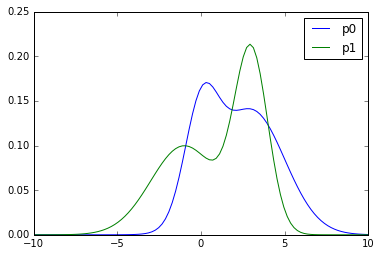

In [218]:
from carl.distributions import Mixture, Normal
p0 = Mixture(components=[Normal(0, 1), Normal(3, 2)], weights=[0.3, 0.7])
p1 = Mixture(components=[Normal(-1, 2), Normal(3, 1)], weights=[0.5, 0.5])

x = np.linspace(-10, 10, 100).reshape(-1, 1)
plt.plot(x, p0.pdf(x), label="p0")
plt.plot(x, p1.pdf(x), label="p1")
plt.legend()
plt.show()

In [219]:
n_samples = 50000

X0 = np.zeros(n_samples).reshape(-1,1)
X1 = np.ones(n_samples).reshape(-1,1)
y0 = p0.rvs(n_samples)
y1 = p1.rvs(n_samples)
X = np.vstack([X0,X1])
y = np.vstack([y0,y1]).ravel()

a, b = -4, 4
mask = (a < y) & (y < b)
X, y = X[mask], y[mask]

In [220]:
n_components = 2

inputs = Input(shape=(1,))
h = Dense(4, activation="relu")(inputs)
h = Dense(4, activation="relu")(h)
h = Dense(4, activation="relu")(h)

mu = Dense(n_components, activation="tanh")(h)
mu = Lambda(lambda x: (x+1.0)/2.0 * (b-a) + a)(mu)
sigma = Dense(n_components, activation=K.exp)(h)
pi = Dense(n_components, activation="softmax")(h)

MDN = Model(input=[inputs], output=[Merge(mode="concat")([mu, sigma, pi])])

In [221]:
def make_loss(n_components, a, b):
    def loss(y_true, y_pred):
        y_true = y_true.ravel()
        
        mu = y_pred[:, :n_components]
        sigma = y_pred[:, n_components:2*n_components]
        pi = y_pred[:, 2*n_components:]
        
        pdf = pi[:, 0] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, 0] *
                          K.exp(-(y_true - mu[:, 0]) ** 2 / (2. * sigma[:, 0] ** 2)))
        
        Fa = pi[:, 0] * 0.5 * (1. + T.erf((a - mu[:, 0]) / (sigma[:, 0] * np.sqrt(2.))))
        Fb = pi[:, 0] * 0.5 * (1. + T.erf((b - mu[:, 0]) / (sigma[:, 0] * np.sqrt(2.))))
        
        for c in range(1, n_components):
            pdf += pi[:, c] * ((1. / np.sqrt(2. * np.pi)) / sigma[:, c] *
                               K.exp(-(y_true - mu[:, c]) ** 2 / (2. * sigma[:, c] ** 2)))
            
            Fa += pi[:, c] * 0.5 * (1. + T.erf((a - mu[:, c]) / (sigma[:, c] * np.sqrt(2.))))
            Fb += pi[:, c] * 0.5 * (1. + T.erf((b - mu[:, c]) / (sigma[:, c] * np.sqrt(2.))))
        
        nll = -K.log(pdf / (Fb - Fa))
        
        return nll.mean()
    
    return loss

In [222]:
MDN.compile(loss=make_loss(n_components, a, b), optimizer=Adam())

In [223]:
MDN.fit(X, y)

Epoch 1/10
83359/83359 [==============================] - 2s - loss: 2.0272     
Epoch 2/10
83359/83359 [==============================] - 2s - loss: 1.8923     
Epoch 3/10
83359/83359 [==============================] - 2s - loss: 1.8914     
Epoch 4/10
83359/83359 [==============================] - 2s - loss: 1.8910     
Epoch 5/10
83359/83359 [==============================] - 2s - loss: 1.8911     
Epoch 6/10
83359/83359 [==============================] - 2s - loss: 1.8909     
Epoch 7/10
83359/83359 [==============================] - 2s - loss: 1.8910     
Epoch 8/10
83359/83359 [==============================] - 2s - loss: 1.8910     
Epoch 9/10
83359/83359 [==============================] - 2s - loss: 1.8908     
Epoch 10/10
83359/83359 [==============================] - 2s - loss: 1.8909     


[ 3.18704891  0.13118696  1.50857389  1.13427782  0.56163532  0.43836468]
[ 2.96819973 -0.86940765  1.00083482  2.04311061  0.5038771   0.4961229 ]


(array([ 0.04213134,  0.04902556,  0.05396216,  0.06494184,  0.07294254,
         0.08409245,  0.09405077,  0.10375374,  0.10690295,  0.10911591,
         0.11822309,  0.11464831,  0.1103075 ,  0.11328649,  0.1016259 ,
         0.09958316,  0.09166758,  0.0930294 ,  0.09702975,  0.10988194,
         0.11507388,  0.14273587,  0.16895092,  0.20223042,  0.22631763,
         0.23882937,  0.24410642,  0.22521116,  0.20231554,  0.15439646]),
 array([ -3.99977197e+00,  -3.73313161e+00,  -3.46649126e+00,
         -3.19985090e+00,  -2.93321054e+00,  -2.66657019e+00,
         -2.39992983e+00,  -2.13328948e+00,  -1.86664912e+00,
         -1.60000877e+00,  -1.33336841e+00,  -1.06672806e+00,
         -8.00087702e-01,  -5.33447346e-01,  -2.66806991e-01,
         -1.66635585e-04,   2.66473720e-01,   5.33114075e-01,
          7.99754430e-01,   1.06639479e+00,   1.33303514e+00,
          1.59967550e+00,   1.86631585e+00,   2.13295621e+00,
          2.39959656e+00,   2.66623692e+00,   2.93287727e+00,
  

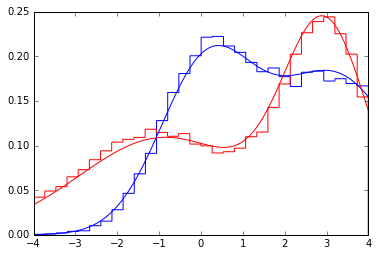

In [224]:
params = MDN.predict(np.array([[0.]])).ravel()
print(params)
p = Mixture(components=[Normal(params[0], params[2]), Normal(params[1], params[3])], weights=[params[4], params[5]])
Fa = p.cdf(np.array([[a]])).ravel()
Fb = p.cdf(np.array([[b]])).ravel()
x = np.linspace(a, b, 100).reshape(-1, 1)
plt.plot(x, p.pdf(x) / (Fb - Fa), c="blue")
plt.hist(y[X.ravel()==0], histtype="step", bins=30, normed=1, color="blue")

params = MDN.predict(np.array([[1.]])).ravel()
print(params)
p = Mixture(components=[Normal(params[0], params[2]), Normal(params[1], params[3])], weights=[params[4], params[5]])
Fa = p.cdf(np.array([[a]])).ravel()
Fb = p.cdf(np.array([[b]])).ravel()
x = np.linspace(a, b, 100).reshape(-1, 1)
plt.plot(x, p.pdf(x) / (Fb - Fa), c="red")
plt.hist(y[X.ravel()==1], histtype="step", bins=30, normed=1, color="red")